In [1]:
from zipfile import MAX_EXTRACT_VERSION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import joblib
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import shap

C:\Users\ASUS\PycharmProjects\PythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Column definitions for the NASA CMAPSS dataset
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i}' for i in range(1, 22)] # s_1, s_2, ..., s_21
col_names = index_names + setting_names + sensor_names

In [6]:
#Read the text we use regex
train_df = pd.read_csv('../data/train_FD001.txt', sep='\s+', header=None, names=col_names)

In [20]:
#Our Data
train_df

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [21]:
#Finding the Rol

#Finding max cycle for every engine
max_cycle= train_df.groupby('unit_nr')['time_cycles'].max().reset_index()
max_cycle.columns =['unit_nr', 'max_cycles']

#Adding back max values to main table
train_df=train_df.merge(max_cycle, on='unit_nr', how='left')

#Calculating RUL = MAX CYCLE - TIME CYCLE
train_df['RUL']=train_df['max_cycles'] - train_df['time_cycles']

#Deleting the max cycle column because we dont need now
train_df.drop('max_cycle', axis=1, inplace=True)


KeyError: "['max_cycle'] not found in axis"

Visualize the DATA

In [22]:
#First we should find the columns with std=0
stats = train_df.describe().T
constant_sensors =stats[stats['std']==0].index.tolist()
print(f"Constant Sensors: {constant_sensors}")
#Dropping the constant columns
train_df.drop(constant_sensors, axis=1, inplace=True)

Constant Sensors: ['setting_3', 's_1', 's_10', 's_18', 's_19']


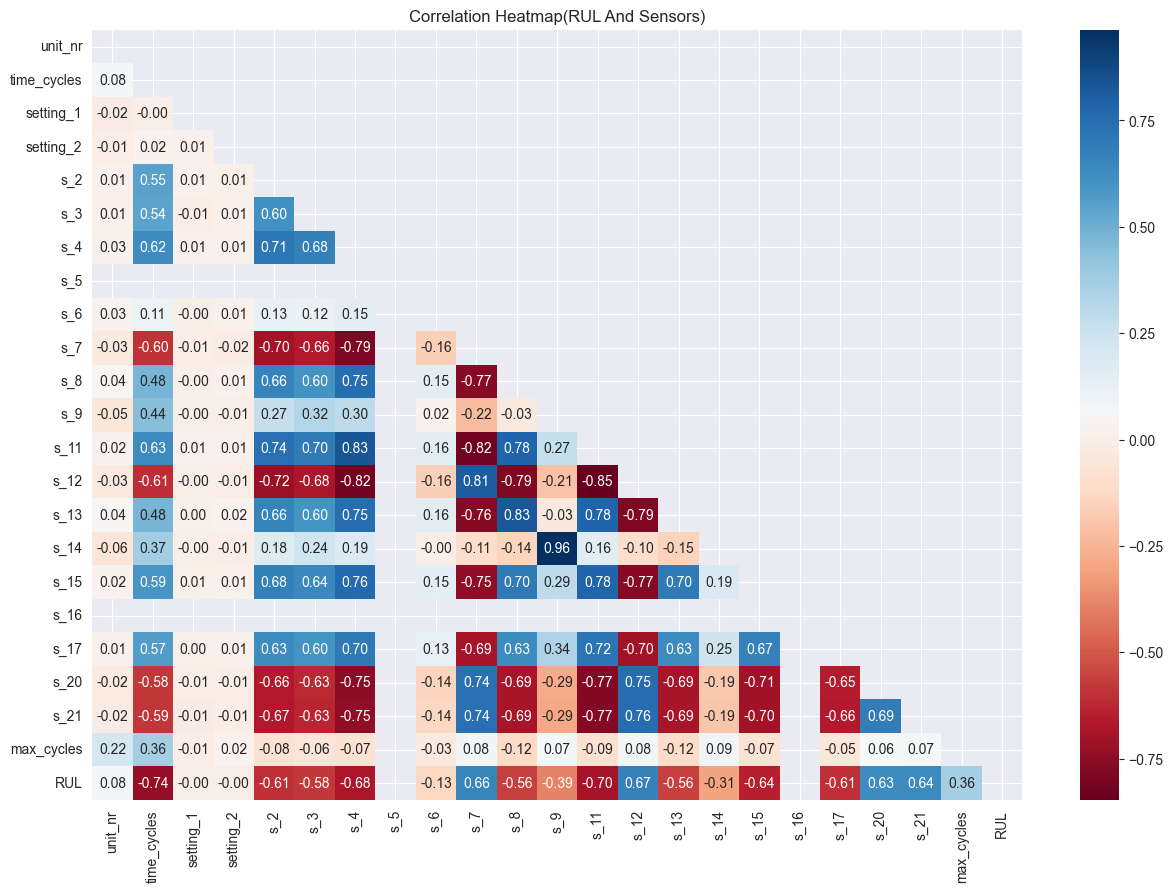

In [23]:
#Correlation between RUL and Sensors
plt.figure(figsize = (15,10))
mask = np.triu(np.ones_like(train_df.corr(),dtype=bool))#Shows lower triangular
sns.heatmap(train_df.corr(), annot=True, fmt=".2f", cmap='RdBu', mask=mask )
plt.title('Correlation Heatmap(RUL And Sensors)')
plt.show()

1. Correlation Heatmap
Interpretation: "The heatmap illustrates the linear relationship between sensor measurements and Remaining Useful Life (RUL). Sensors such as s_2, s_4, and s_11 show strong negative correlations (close to -1), indicating that as these values increase, the engine’s life significantly decreases. These features are the primary candidates for training our predictive model."

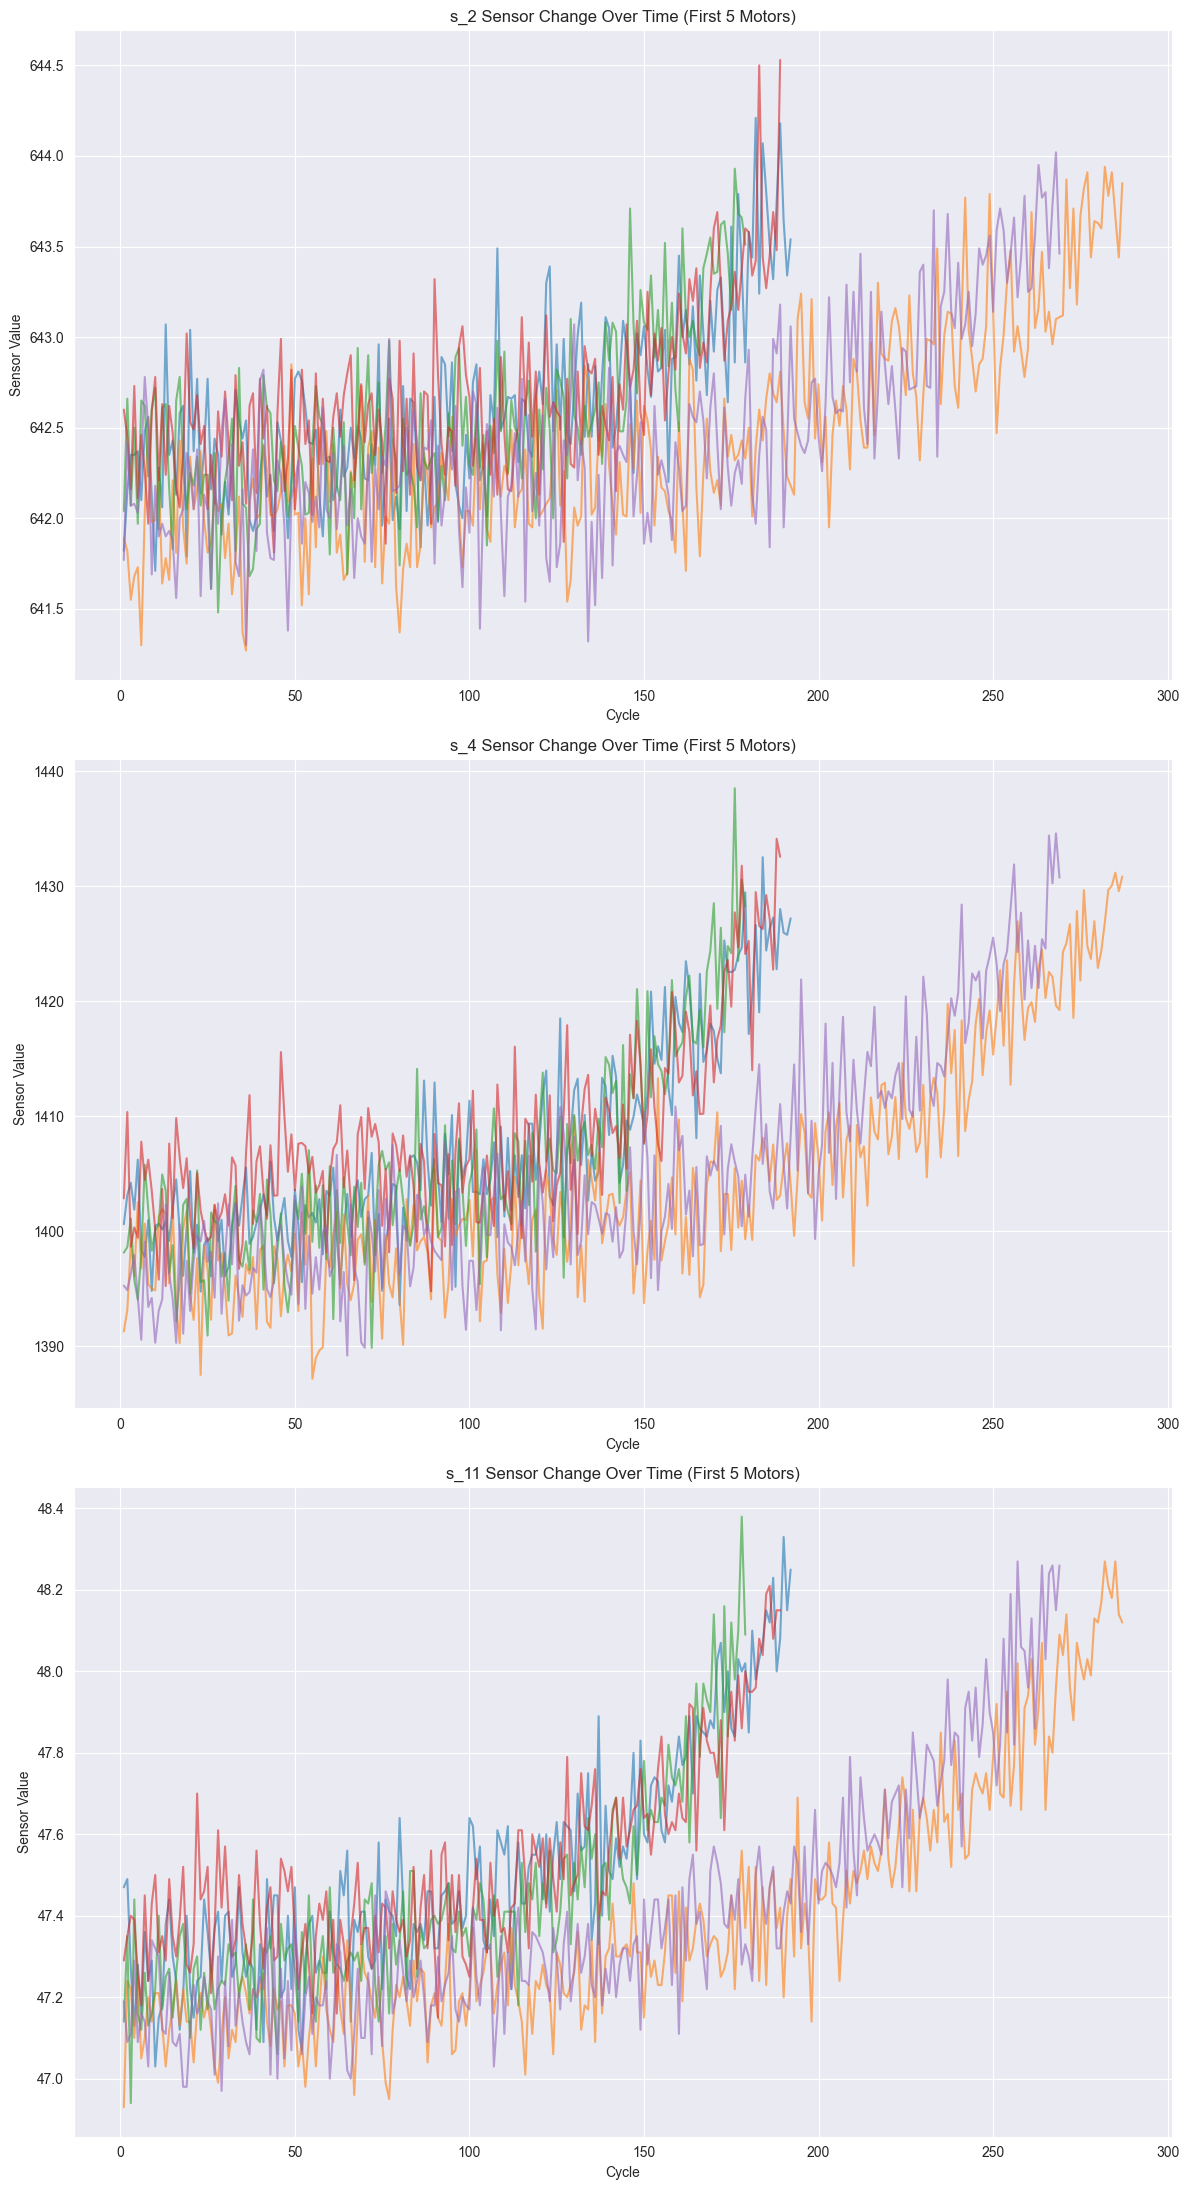

In [24]:
#Deterioration Analysis Over Time
features=["s_2","s_4","s_11"]
fig, axes=plt.subplots(len(features), 1, figsize=(12,22))
for i, feature in enumerate(features):
    #first 5 engine
    for unit in train_df["unit_nr"].unique()[:5]:
        sample = train_df[train_df["unit_nr"]==unit]
        axes[i].plot(sample["time_cycles"], sample[feature], alpha=0.6)

    axes[i].set_title(f"{feature} Sensor Change Over Time (First 5 Motors)")
    axes[i].set_ylabel('Sensor Value')
    axes[i].set_xlabel('Cycle')

plt.tight_layout()
plt.show()


2. Sensor Trend Analysis
Interpretation: "These time-series plots reveal the degradation patterns of individual engine units. We observe distinct upward or downward drifts in sensor readings as the engines approach their failure points. While there is inherent measurement noise, the clear underlying trends confirm that the model can learn to distinguish between healthy and faulty states."

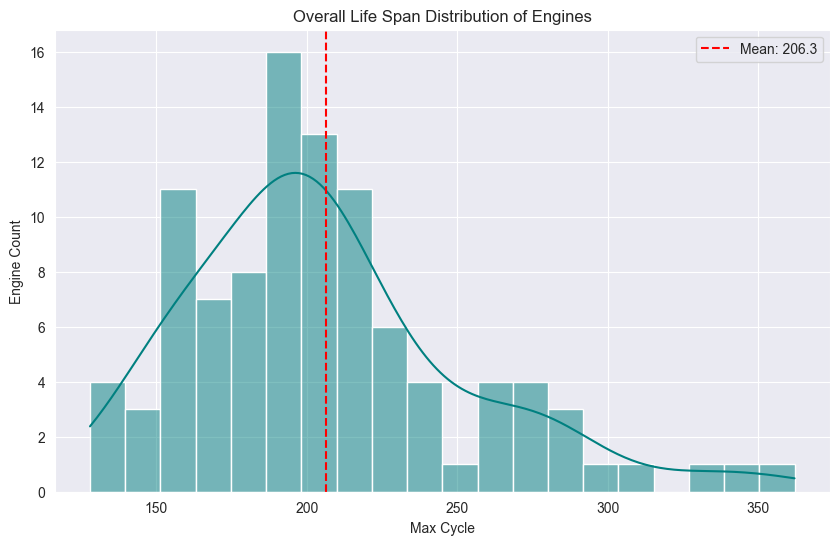

In [25]:
#Calcualte at what cycle each motor failed.
lifespans = train_df.groupby('unit_nr')['time_cycles'].max()

plt.figure(figsize=(10, 6))
sns.histplot(lifespans, bins=20, kde=True, color='teal')
plt.axvline(lifespans.mean(), color='red', linestyle='--', label=f'Mean: {lifespans.mean():.1f}')
plt.title("Overall Life Span Distribution of Engines")
plt.xlabel("Max Cycle")
plt.ylabel("Engine Count")
plt.legend()
plt.show()

3. Lifespan Distribution (Histogram)
Interpretation: "The histogram displays the distribution of maximum flight cycles before failure across the dataset. The wide variance in lifespans (ranging from approximately 150 to over 300 cycles) demonstrates that engine failure is not strictly time-dependent. This variability justifies the need for a sensor-based Machine Learning approach over simple threshold-based maintenance."

Feature Engineering

In [26]:
#1. Rolling Statistics
#Window Size
window_size = 10
# Sensör list after the cleaning
sensors = [col for col in train_df.columns if col.startswith('s_')]

# Calculation for every engine
for sensor in sensors:
    # Rolling Mean
    train_df[f'{sensor}_av'] = train_df.groupby('unit_nr')[sensor].transform(lambda x: x.rolling(window=window_size).mean())
    # Rolling STD
    train_df[f'{sensor}_sd'] = train_df.groupby('unit_nr')[sensor].transform(lambda x: x.rolling(window=window_size).std())

# Clean the first 10 row because it will be nan
train_df.dropna(inplace=True)

In [27]:
#2. Lag Features
# Adding the value from the previous loop as a new column
for sensor in sensors:
    train_df[f'{sensor}_lag'] = train_df.groupby('unit_nr')[sensor].shift(1)

train_df.dropna(inplace=True) # Delete the spaces after shift

In [28]:
# 3. Trend Calculation: Rate of change over the last 10 cycles.
def calculate_slope(series):
    y = series.values
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0] if len(y) > 1 else 0

for sensor in sensors:
    # Slope
    train_df[f'{sensor}_slope'] = train_df.groupby('unit_nr')[sensor].transform(
        lambda x: x.rolling(window=10).apply(calculate_slope)
    )
    # Z-Score (For anomaly detection: How far is the value from the mean?)
    train_df[f'{sensor}_zscore'] = train_df.groupby('unit_nr')[sensor].transform(
        lambda x: (x - x.mean()) / x.std()
    )

train_df.fillna(0, inplace=True) # Fill nan

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
#3. Min-Max Scaling
scaler = MinMaxScaler()
features = [col for col in train_df.columns if col not in ['unit_nr', 'time_cycles', 'RUL']]
train_df[features] = scaler.fit_transform(train_df[features])


Model

In [31]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [32]:
units = train_df["unit_nr"].unique()
train_units= units[:80]
test_units = units[80:]

In [33]:
train_data =train_df[train_df['unit_nr'].isin(train_units)]
test_data =train_df[train_df['unit_nr'].isin(test_units)]

X_train = train_data.drop(['unit_nr','time_cycles', 'RUL'], axis=1)
y_train = train_data['RUL']

X_test = test_data.drop(['unit_nr','time_cycles', 'RUL'], axis=1)
y_test = test_data['RUL']

In [34]:
model = XGBRegressor(n_estimators=661, learning_rate=0.026, max_depth=3,random_state=42,tree_method="hist")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [35]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("RMSE: ",rmse)
print("MAE", mae)
print("R2 Score: ",r2)

RMSE:  19.803916251008364
MAE 14.590975761413574
R2 Score:  0.9304558038711548


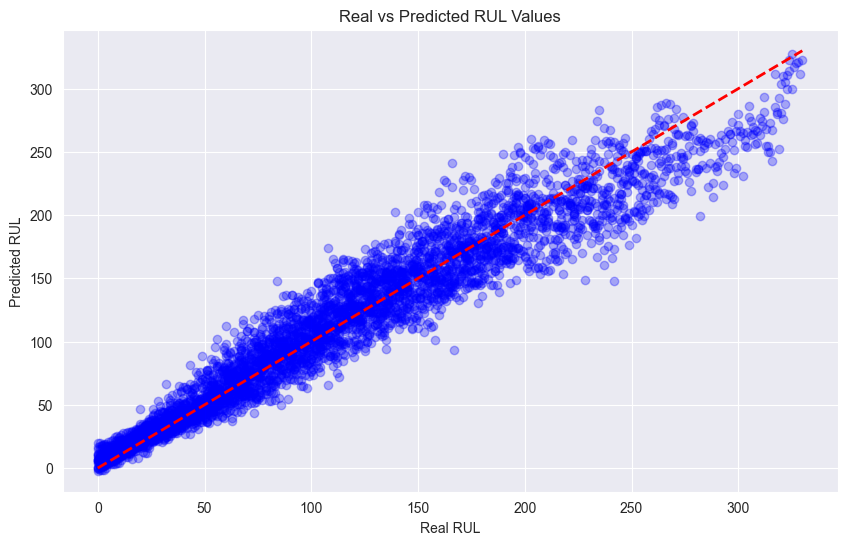

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Real RUL')
plt.ylabel('Predicted RUL')
plt.title('Real vs Predicted RUL Values')
plt.show()

Feature Importance

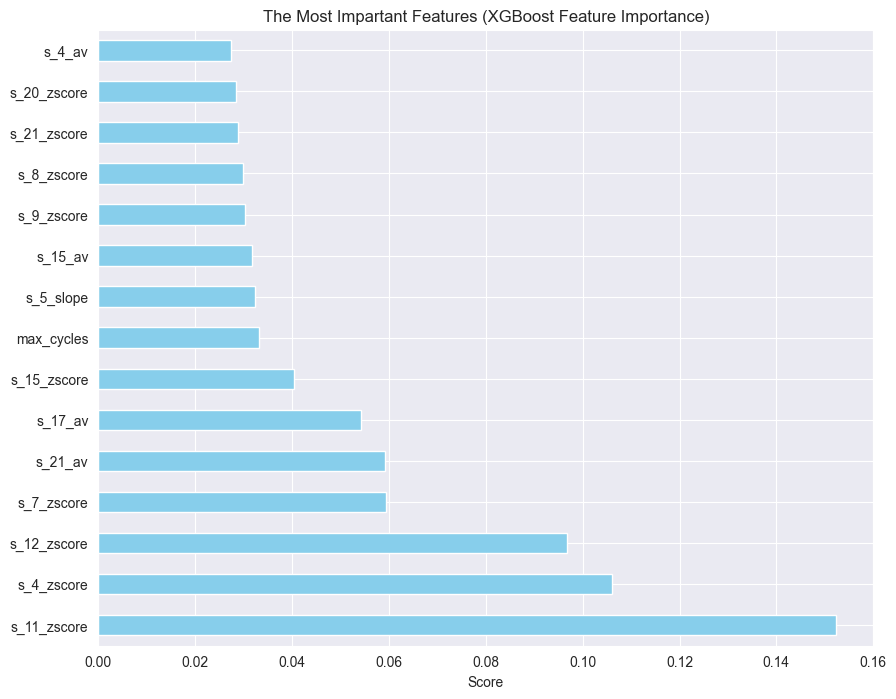

In [37]:
# Visualize the most important features
plt.figure(figsize=(10, 8))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh', color='skyblue')
plt.title("The Most Impartant Features (XGBoost Feature Importance)")
plt.xlabel("Score")
plt.show()

C:\Users\ASUS\PycharmProjects\PythonProject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


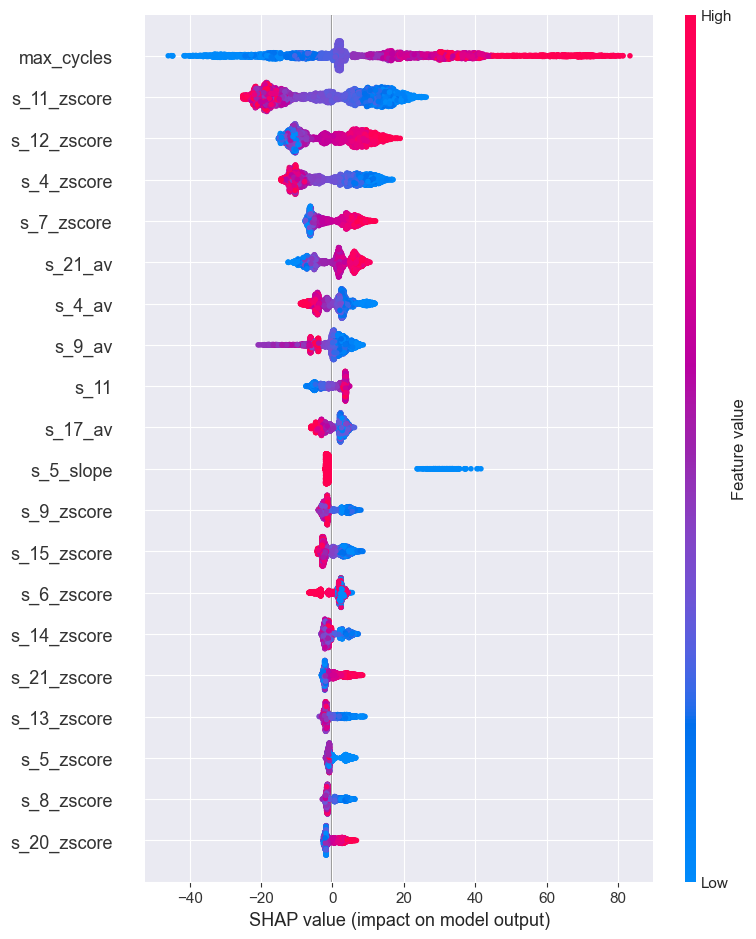

In [38]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [39]:
import joblib

# Saving Model
joblib.dump(model, 'xgboost_model.pkl')
joblib.dump(scaler, 'minmax_scaler.pkl')

['minmax_scaler.pkl']

In [40]:
print(X_train.columns.tolist())

['setting_1', 'setting_2', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_20', 's_21', 'max_cycles', 's_2_av', 's_2_sd', 's_3_av', 's_3_sd', 's_4_av', 's_4_sd', 's_5_av', 's_5_sd', 's_6_av', 's_6_sd', 's_7_av', 's_7_sd', 's_8_av', 's_8_sd', 's_9_av', 's_9_sd', 's_11_av', 's_11_sd', 's_12_av', 's_12_sd', 's_13_av', 's_13_sd', 's_14_av', 's_14_sd', 's_15_av', 's_15_sd', 's_16_av', 's_16_sd', 's_17_av', 's_17_sd', 's_20_av', 's_20_sd', 's_21_av', 's_21_sd', 's_2_lag', 's_3_lag', 's_4_lag', 's_5_lag', 's_6_lag', 's_7_lag', 's_8_lag', 's_9_lag', 's_11_lag', 's_12_lag', 's_13_lag', 's_14_lag', 's_15_lag', 's_16_lag', 's_17_lag', 's_20_lag', 's_21_lag', 's_2_slope', 's_2_zscore', 's_3_slope', 's_3_zscore', 's_4_slope', 's_4_zscore', 's_5_slope', 's_5_zscore', 's_6_slope', 's_6_zscore', 's_7_slope', 's_7_zscore', 's_8_slope', 's_8_zscore', 's_9_slope', 's_9_zscore', 's_11_slope', 's_11_zscore', 's_12_slope', 's_12_zscore', 's_

In [41]:
from sklearn.cluster import KMeans

In [48]:
from sklearn.cluster import KMeans
import joblib

# 1. Load FD004 Data
train_fd004 = pd.read_csv('../data/train_FD004.txt', sep='\s+', header=None, names=col_names)

# 2. RUL Calculation (Piecewise - capped at 125)
# Finding the maximum cycle for each engine
max_cycle_fd004 = train_fd004.groupby('unit_nr')['time_cycles'].max().reset_index()
max_cycle_fd004.columns = ['unit_nr', 'max_cycles']
train_fd004 = train_fd004.merge(max_cycle_fd004, on='unit_nr', how='left')

# Calculating RUL = MAX CYCLE - CURRENT TIME CYCLE
train_df_fd004['RUL'] = train_fd004['max_cycles'] - train_fd004['time_cycles']

# Piecewise RUL: Clipping values at 125 to avoid overwhelming the model with high target values
train_fd004['RUL'] = train_fd004['RUL'].clip(upper=125)

# Dropping redundant columns
train_fd004.drop('max_cycles', axis=1, inplace=True)

# 3. Creating 6 Flight Regimes with K-Means
# Settings 1, 2, and 3 define the specific flight conditions

kmeans = KMeans(n_clusters=6, n_init=10, random_state=42)
train_fd004['regime'] = kmeans.fit_predict(train_fd004[['setting_1', 'setting_2', 'setting_3']])

# Save the K-Means model (Required for the inference script/App.py)
joblib.dump(kmeans, 'kmeans_fd004.pkl')
print("Flight regimes determined and KMeans saved successfully.")

Uçuş rejimleri belirlendi ve KMeans kaydedildi.


In [1]:
# Identify active sensors (excluding constant sensors for FD004)
sensors = [col for col in train_fd004.columns if col.startswith('s_')]

def regime_specific_standardization(df, sensor_list):
    for s in sensor_list:
        # Standardize (Z-score) each sensor within its respective regime group
        # Formula: (x - mean) / std
        df[s] = df.groupby('regime')[s].transform(lambda x: (x - x.mean()) / (x.std() + 1e-9))
    return df

# Apply the standardization to the training set
train_fd004 = regime_specific_standardization(train_fd004, sensors)

print("Regime-based normalization completed.")

NameError: name 'train_fd004' is not defined

In [50]:
# Feature Engineering Loop
for sensor in sensors:
    # Rolling Statistics: Capture local average and volatility
    train_fd004[f'{sensor}_av'] = train_fd004.groupby('unit_nr')[sensor].transform(lambda x: x.rolling(window=10).mean())
    train_fd004[f'{sensor}_sd'] = train_fd004.groupby('unit_nr')[sensor].transform(lambda x: x.rolling(window=10).std())

    # Lag Features: Provide the model with the value from the previous time step
    train_fd004[f'{sensor}_lag'] = train_fd004.groupby('unit_nr')[sensor].shift(1)

    # Slope: Calculate the rate of change over the last 10 cycles
    train_fd004[f'{sensor}_slope'] = train_fd004.groupby('unit_nr')[sensor].transform(
        lambda x: x.rolling(window=10).apply(calculate_slope)
    )

    # Z-Score: Distance from the mean to detect anomalies
    train_fd004[f'{sensor}_zscore'] = train_fd004.groupby('unit_nr')[sensor].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-9)
    )

# Fill missing values created by rolling/lag calculations with 0
train_fd004.fillna(0, inplace=True)
# Drop any remaining rows with missing values
train_fd004.dropna(inplace=True)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22360\4092299021.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_fd004[f'{sensor}_av'] = train_fd004.groupby('unit_nr')[sensor].transform(lambda x: x.rolling(window=10).mean())
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22360\4092299021.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_fd004[f'{sensor}_sd'] = train_fd004.groupby('unit_nr')[sensor].transform(lambda x: x.rolling(window=10).std())
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22360\4092299021.py:7: Performan

In [51]:
# --- 1. Train-Test Split (Unit-Based) ---
# We split the data by engine ID (unit_nr) to ensure the model sees completely unseen engines during testing.
units_4 = train_fd004["unit_nr"].unique()
train_units_4 = units_4[:200]  # Using 200 out of 249 engines for training
test_units_4 = units_4[200:]

# Filter the datasets based on the identified units
train_data_4 = train_fd004[train_fd004['unit_nr'].isin(train_units_4)]
test_data_4 = train_fd004[train_fd004['unit_nr'].isin(test_units_4)]

#

# Dropping identifiers and target columns to create the feature set (X) and target (y)
X_train_4 = train_data_4.drop(['unit_nr', 'time_cycles', 'RUL', 'regime'], axis=1)
y_train_4 = train_data_4['RUL']
X_test_4 = test_data_4.drop(['unit_nr', 'time_cycles', 'RUL', 'regime'], axis=1)
y_test_4 = test_data_4['RUL']

# --- 2. Model Definition & Training ---
# Model configuration: Using deeper trees and a higher number of estimators for the complex FD004 dataset.
#
model_fd004 = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=5,
    random_state=42,
    tree_method="hist"
)

# Fitting the model to the training data
model_fd004.fit(X_train_4, y_train_4)

# --- 3. Model Persistence ---
# Saving the trained Expert Model for deployment (e.g., in app.py)
joblib.dump(model_fd004, 'xgboost_fd004.pkl')

print("FD004 Expert Model trained and saved successfully!")

FD004 Uzman Modeli eğitildi ve kaydedildi!


In [52]:
def calculate_nasa_score(y_true, y_pred):
    d = y_pred - y_true
    score = 0
    for i in d:
        if i < 0:
            # Penalty for early prediction
            score += np.exp(-i / 13) - 1
        else:
            # Higher penalty for late prediction (overestimation)
            score += np.exp(i / 10) - 1
    return score

# 2. Load Test Data
# Note: Ensure the file paths are correct for your local environment
test_fd004 = pd.read_csv('../data/test_FD004.txt', sep='\s+', header=None, names=col_names)
true_rul_fd004 = pd.read_csv('../data/RUL_FD004.txt', sep='\s+', header=None, names=['true_RUL'])

# 3. Apply "Regime-Based" Preprocessing to Test Data
# A. Determine Flight Regimes (using Trained KMeans model)
test_fd004['regime'] = kmeans.predict(test_fd004[['setting_1', 'setting_2', 'setting_3']])

# B. Normalize Each Regime Internally (Critical Step!)
sensors = [col for col in test_fd004.columns if col.startswith('s_')]
for s in sensors:
    # Standardize sensors within their respective flight regimes
    test_fd004[s] = test_fd004.groupby('regime')[s].transform(lambda x: (x - x.mean()) / (x.std() + 1e-9))

# C. Feature Engineering (Rolling Statistics, Lag, Slope, Z-Score)
for s in sensors:
    # Rolling Average (10-cycle window)
    test_fd004[f'{s}_av'] = test_fd004.groupby('unit_nr')[s].transform(lambda x: x.rolling(window=10).mean())
    # Rolling Standard Deviation
    test_fd004[f'{s}_sd'] = test_fd004.groupby('unit_nr')[s].transform(lambda x: x.rolling(window=10).std())
    # Lag Feature (Value from previous cycle)
    test_fd004[f'{s}_lag'] = test_fd004.groupby('unit_nr')[s].shift(1)
    # Slope (Trend rate of change)
    test_fd004[f'{s}_slope'] = test_fd004.groupby('unit_nr')[s].transform(lambda x: x.rolling(window=10).apply(calculate_slope))
    # Z-Score (Anomaly detection within the unit)
    test_fd004[f'{s}_zscore'] = test_fd004.groupby('unit_nr')[s].transform(lambda x: (x - x.mean()) / (x.std() + 1e-9))

# Fill missing values created by rolling windows/lags
test_fd004.fillna(0, inplace=True)

# 4. Select the LAST Flight Row for Each Engine (Inference is performed here)
X_test_final = test_fd004.groupby('unit_nr').tail(1).drop(['unit_nr', 'time_cycles', 'regime'], axis=1)

# 5. Make Prediction with the New Model
y_pred_final = model_fd004.predict(X_test_final)
y_true_final = true_rul_fd004['true_RUL'].values

# 6. Calculate Performance Metrics
new_rmse = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
new_mae = mean_absolute_error(y_true_final, y_pred_final)
new_s_score = calculate_nasa_score(y_true_final, y_pred_final)

print("✅ ------ NEW REGIME-BASED MODEL SCORES (FD004) ------")
print(f"New RMSE: {new_rmse:.2f} (Previous: 66.17)")
print(f"New MAE:  {new_mae:.2f} (Previous: 54.59)")
print(f"New S-Score: {new_s_score:.2f} (Previous: 798,892.57)")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22360\1727279812.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_fd004[f'{s}_sd'] = test_fd004.groupby('unit_nr')[s].transform(lambda x: x.rolling(window=10).std())
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22360\1727279812.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_fd004[f'{s}_lag'] = test_fd004.groupby('unit_nr')[s].shift(1)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22360\1727279812.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

✅ ------ YENİ REJİM BAZLI MODEL SKORLARI (FD004) ------
Yeni RMSE: 63.96 (Önceki: 66.17)
Yeni MAE:  52.85 (Önceki: 54.59)
Yeni S-Score: 615197.43 (Önceki: 798,892.57)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_22360\1727279812.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_fd004[f'{s}_slope'] = test_fd004.groupby('unit_nr')[s].transform(lambda x: x.rolling(window=10).apply(calculate_slope))
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22360\1727279812.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_fd004[f'{s}_zscore'] = test_fd004.groupby('unit_nr')[s].transform(lambda x: (x - x.mean()) / (x.std() + 1e-9))
